In [3]:
import sympy 
sympy.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control


import scipy.optimize
from tbcontrol.responses import fopdt, sopdt
from ipywidgets import interact

def resultplot1(K, tau, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, fopdt(ts, K, tau, theta, y0), color='red')
    plt.grid(True)

def resultplot2(K, tau, zeta, theta, y0):
    plt.figure(figsize=(21, 7))
    plt.scatter(ts, ym)
    plt.plot(ts, sopdt(ts, K, tau, zeta,theta, y0), color='red')
    plt.grid(True)
    


## Diseño directo

Esta técnica parte del supuesto de definir el comportamiento deseado para el sistema en lazo cerrado, escribir una función de transferencia de lazo cerrado de una forma apropiada y despejar el compensador

In [4]:
GP = control.tf([0.27], [4.489, 1])
GP

TransferFunction(array([0.27]), array([4.489, 1.   ]))

In [5]:
a0= pd.read_csv('C:\\Users\\jgall\\OneDrive\\Documentos\\ControlAnalogo\\DatosJS.csv')
df = a0 [a0['Tiempo'] > 19] 
df.head()

,Tiempo,Entrada,Salida
39,19.5,20,6.785451
40,20.0,80,6.755044
41,20.5,80,6.724637
42,21.0,80,7.552863
43,21.5,80,9.080447


In [6]:
ym = df.Salida-20
ts = df.Tiempo-20
interact(resultplot2, K=(0.0, 20.0), tau=(0., 20.), 
         theta=(0., 20.), zeta = (0, 20.0), y0=(-20., 20.));

interactive(children=(FloatSlider(value=10.0, description='K', max=20.0), FloatSlider(value=10.0, description=…

In [7]:
p_inicial = [16.4, 2, 1.3, 0.0, -13.3]
[K_1, tau_1, zeta_1, theta_1, y0_1], pcov = scipy.optimize.curve_fit(sopdt, ts, ym, p_inicial)
[K_1, tau_1, zeta_1, theta_1, y0_1]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The MathtextBa

In [8]:
k_11=K_1/60
k_11

Observe que el k_1 es dividido entre 60, esto se debe a que a la hora de seleccionar la función de transferencia del sistema, nuestra ganancia funciona bien en una escalón de 0 a 1, teniendo esto en cuenta la ganancia se tiene que ajustar para desarrollar un buen controlador según el escalón propuesto. 

In [9]:
n_pade,d_pade = control.pade(theta_1,1)
GPP_pade = control.tf([0.27],[4.489,1])*control.tf(n_pade,d_pade)
GPP_pade

TransferFunction(array([-0.27      ,  1.21489428]), array([ 4.489     , 21.19874232,  4.49960845]))

In [15]:
tauC = 3

Se calculan los parámetros del PID

In [16]:
KC1 = -2*tau_1*zeta_1/(k_11*(theta_1 - tauC))
TD1 = tau_1/(2*zeta_1)
TI1 = 2*tau_1*zeta_1
[KC1,TI1,TD1]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The MathtextBa

In [17]:
GC_PID1 = KC1*(1 + control.tf(1,[TI1,0]) + control.tf([TD1,0],1))
GC_PID1

TransferFunction(array([13.0722758 , 33.60378483,  6.93250341]), array([4.84727995, 0.        ]))

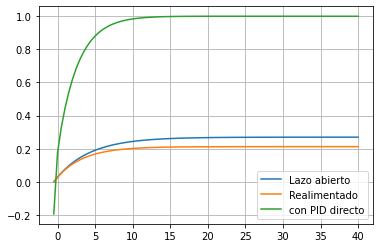

In [18]:
_, yLA = control.step_response(GP,ts)
_, yLC1 = control.step_response(control.feedback(GP,1),ts)
_, yLCPID1 = control.step_response(control.feedback(GC_PID1*GPP_pade,1),ts)

plt.plot(ts,yLA,
         ts,yLC1,
         ts,yLCPID1)
plt.legend(('Lazo abierto','Realimentado','con PID directo'))
plt.grid()

Este diseño se aplico en la planta del laboratorio y se obtuvo los siguientes resultados 

Se ensayo varios métodos y con este nos dio un resultado más decente.





# Primer resultado 

In [16]:
a0 = pd.read_csv('C:\\Users\\jgall\\OneDrive\\Documentos\\ControlAnalogo\\DATOS\\PID_1JDG.csv')
a0

,Tiempo,Referencia,Error,Señal de control,Salida
0,0.0,5,0.007108,0.105775,4.992892
1,1.0,5,0.050546,0.727015,4.949454
2,2.0,5,0.441492,6.424662,4.558508
3,3.0,5,1.313156,18.250509,3.686844
4,4.0,5,1.455055,19.366911,3.544945
...,...,...,...,...,...
86,86.0,10,0.073952,34.686830,9.926048
87,87.0,10,0.110150,35.108297,9.889850
88,88.0,10,0.131870,35.654007,9.868130
89,89.0,10,0.114494,35.840960,9.885506


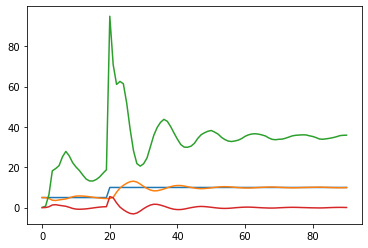

In [26]:
plt.plot(a0["Tiempo"],a0["Referencia"],  
         a0["Tiempo"],1*a0["Salida"],
        a0["Tiempo"],1*a0["Señal de control"],
        a0["Tiempo"],1*a0[""])  

Observe que se presentan oscilaciones aunque la respuesta deseada se modeló como un sistema de primer orden con tiempo muerto.

# Segundo resultado 

In [21]:
a1 = pd.read_csv('C:\\Users\\jgall\\OneDrive\\Documentos\\ControlAnalogo\\DATOS\\PID_2JDG.csv')
a1

,Tiempo,Referencia,Error,Señal de control,Salida
0,0.0,5,0.830990,2.473290,4.169010
1,1.0,5,0.668820,1.401546,4.331180
2,2.0,5,0.793343,2.675502,4.206657
3,3.0,5,1.497045,5.316193,3.502955
4,4.0,5,2.141382,7.487760,2.858618
...,...,...,...,...,...
86,86.0,10,0.003002,35.810083,9.996998
87,87.0,10,-0.011477,35.822638,10.011477
88,88.0,10,-0.036092,35.762489,10.036092
89,89.0,10,-0.052020,35.721644,10.052020


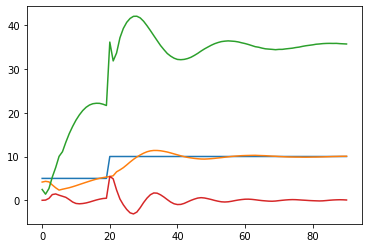

In [27]:
plt.plot(a1["Tiempo"],a1["Referencia"],  
         a1["Tiempo"],1*a1["Salida"],
        a1["Tiempo"],1*a1["Señal de control"],
         a0["Tiempo"],1*a0["Error"])  

Para mejorar el comportamiento del controlador utilizamos un método que es dividir la parte proporcional entre 5 o 7.5, esto con el fin de logara disminuir un poco la oscilación y un tiempo de establecimiento más rápido. 

Desarrollando esta actividad tuvimos algunos inconvenientes a la hora de controlar el sistema, ya que la ganancia de nuestra funciona de trasferencia no funcionaba bien cuando se cambiaba el escalón, luego de tener estas cosas en cuenta el diseño del PID funciono mejor.